# Renewable Generation

This tutorial explores renewable generation modeling in PyPSA-GB, including wind, solar, and hydro.

## What You'll Learn

- Renewable capacity and distribution
- Capacity factor analysis
- Weather-dependent generation profiles
- Curtailment and network constraints
- Correlation between renewable sources

## 1. Setup

In [1]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import folium
from pyproj import Transformer

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

colors = {
    'wind_onshore': '#3B6182', 'wind_offshore': '#6BAED6', 'solar_pv': '#FFBB00',
    'large_hydro': '#0868AC', 'small_hydro': '#7FCDBB', 'marine': '#1F78B4'
}

print(f"PyPSA version: {pypsa.__version__}")

PyPSA version: 1.0.7


## 2. Load Network

In [2]:
# Load a solved network with renewables
n = pypsa.Network("../../../resources/network/Historical_2023_etys_solved.nc")

print(f"Network loaded")
print(f"  Snapshots: {len(n.snapshots)}")
print(f"  Generators: {len(n.generators)}")

INFO:pypsa.network.io:Imported network 'Historical_2023_etys (Full)' has buses, carriers, generators, lines, links, loads, storage_units, sub_networks, transformers


Network loaded
  Snapshots: 168
  Generators: 4766


## 3. Renewable Capacity Overview

In [3]:
# Filter renewable generators
renewable_carriers = ['wind_onshore', 'wind_offshore', 'solar_pv', 'large_hydro', 'small_hydro', 'marine']
renewables = n.generators[n.generators.carrier.isin(renewable_carriers)]

print(f"Renewable generators: {len(renewables)}")

# Capacity by type
capacity = renewables.groupby('carrier')['p_nom'].sum() / 1000  # GW
print("\nInstalled Capacity (GW):")
for carrier, cap in capacity.sort_values(ascending=False).items():
    print(f"  {carrier}: {cap:.2f} GW")
    
print(f"\nTotal Renewable: {capacity.sum():.2f} GW")

Renewable generators: 2104

Installed Capacity (GW):
  wind_offshore: 14.68 GW
  wind_onshore: 12.89 GW
  solar_pv: 9.02 GW
  large_hydro: 0.41 GW
  small_hydro: 0.15 GW

Total Renewable: 37.15 GW


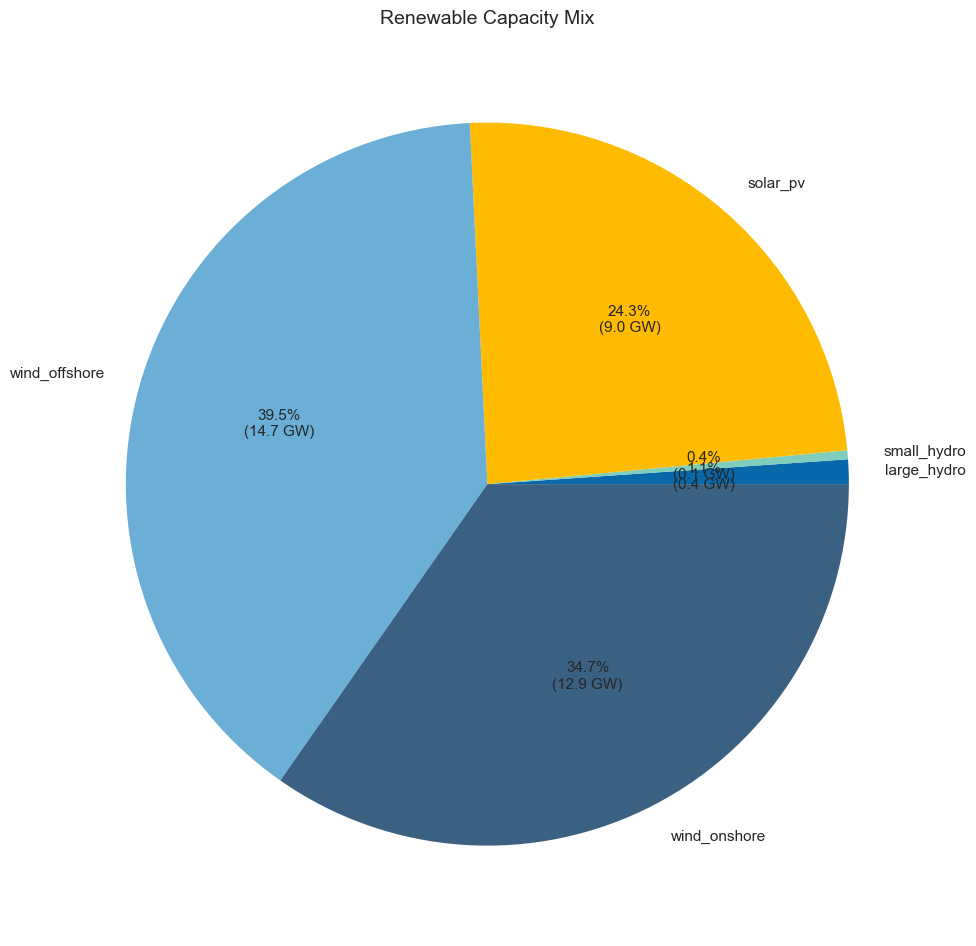

In [4]:
# Capacity pie chart
fig, ax = plt.subplots(figsize=(10, 10))

capacity_plot = capacity[capacity > 0.1]  # Only show > 100 MW
pie_colors = [colors.get(c, '#888888') for c in capacity_plot.index]

wedges, texts, autotexts = ax.pie(
    capacity_plot, labels=capacity_plot.index,
    autopct=lambda pct: f'{pct:.1f}%\n({pct/100*capacity_plot.sum():.1f} GW)',
    colors=pie_colors, textprops={'fontsize': 11}
)

ax.set_title('Renewable Capacity Mix', fontsize=14)
plt.tight_layout()
plt.show()

## 4. Capacity Factor Analysis

The capacity factor is the ratio of actual generation to potential generation if running at full capacity.

In [5]:
# Calculate capacity factors
cf_data = []

for carrier in renewable_carriers:
    carrier_gens = n.generators[n.generators.carrier == carrier].index
    carrier_gens = carrier_gens[carrier_gens.isin(n.generators_t.p.columns)]
    
    if len(carrier_gens) > 0:
        generation = n.generators_t.p[carrier_gens].sum().sum()
        capacity_mw = n.generators.loc[carrier_gens, 'p_nom'].sum()
        max_gen = capacity_mw * len(n.snapshots)
        
        if max_gen > 0:
            cf = generation / max_gen * 100
            cf_data.append({'Carrier': carrier, 'Capacity Factor (%)': cf})

cf_df = pd.DataFrame(cf_data).set_index('Carrier')
print("Capacity Factors:")
print(cf_df.round(1).to_string())

Capacity Factors:
               Capacity Factor (%)
Carrier                           
wind_onshore                  32.2
wind_offshore                 46.6
solar_pv                      18.2
large_hydro                   33.8
small_hydro                   22.5


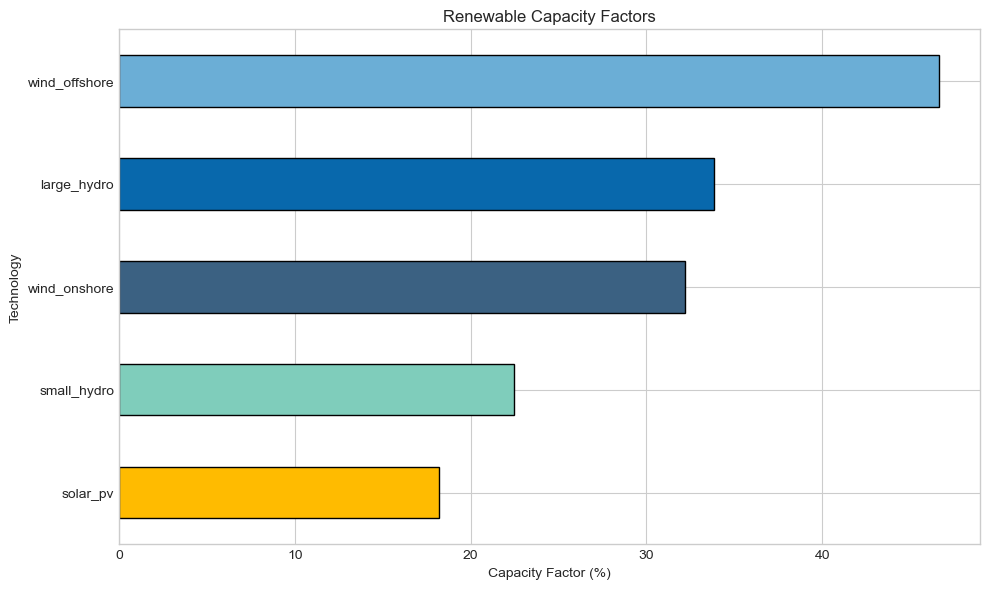

In [6]:
# Capacity factor bar chart
fig, ax = plt.subplots(figsize=(10, 6))

cf_sorted = cf_df.sort_values('Capacity Factor (%)', ascending=True)
bar_colors = [colors.get(c, '#888888') for c in cf_sorted.index]

cf_sorted['Capacity Factor (%)'].plot(kind='barh', ax=ax, color=bar_colors, edgecolor='black')

ax.set_xlabel('Capacity Factor (%)')
ax.set_ylabel('Technology')
ax.set_title('Renewable Capacity Factors')

plt.tight_layout()
plt.show()

## 5. Generation Profiles

In [7]:
# Aggregate generation by carrier
renewable_gen = pd.DataFrame()

for carrier in renewable_carriers:
    carrier_gens = n.generators[n.generators.carrier == carrier].index
    carrier_gens = carrier_gens[carrier_gens.isin(n.generators_t.p.columns)]
    if len(carrier_gens) > 0:
        renewable_gen[carrier] = n.generators_t.p[carrier_gens].sum(axis=1) / 1000  # GW

print("Generation Summary (GW):")
print(renewable_gen.describe().round(2))

Generation Summary (GW):
       wind_onshore  wind_offshore  solar_pv  large_hydro  small_hydro
count        168.00         168.00    168.00       168.00       168.00
mean           4.15           6.85      1.64         0.14         0.03
std            1.12           2.96      1.92         0.17         0.04
min            0.80           1.19     -0.00         0.03         0.01
25%            3.62           4.55      0.00         0.03         0.01
50%            4.38           7.07      0.40         0.03         0.01
75%            4.89           9.45      3.60         0.40         0.07
max            6.05          12.19      5.35         0.41         0.10


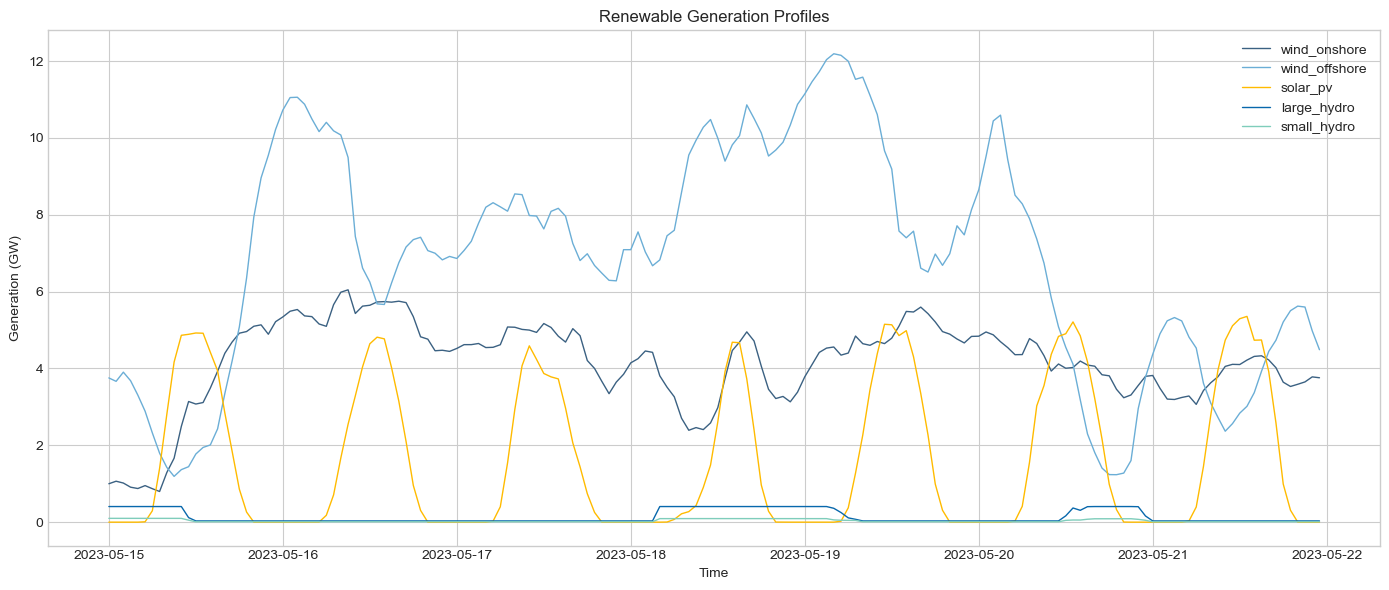

In [8]:
# Time series plot
fig, ax = plt.subplots(figsize=(14, 6))

for col in renewable_gen.columns:
    ax.plot(renewable_gen.index, renewable_gen[col], 
            color=colors.get(col, '#888888'), label=col, linewidth=1)

ax.set_ylabel('Generation (GW)')
ax.set_xlabel('Time')
ax.set_title('Renewable Generation Profiles')
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

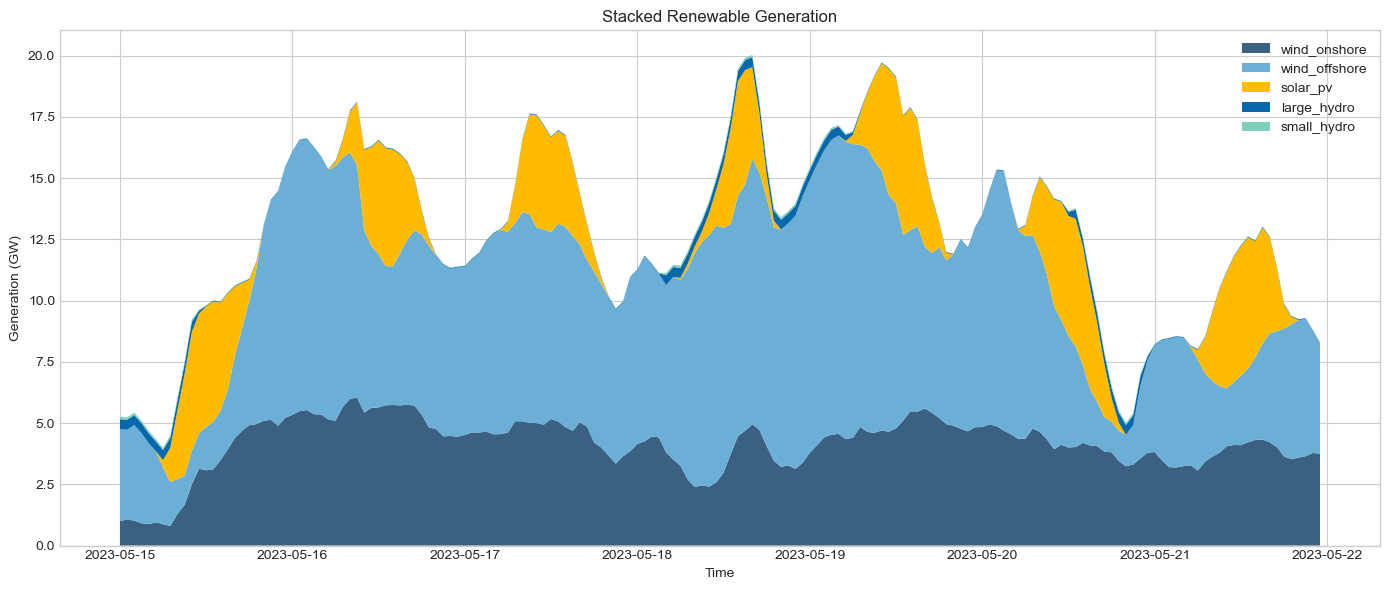

In [9]:
# Stacked area chart
fig, ax = plt.subplots(figsize=(14, 6))

plot_colors = [colors.get(c, '#888888') for c in renewable_gen.columns]
ax.stackplot(renewable_gen.index, renewable_gen.T, labels=renewable_gen.columns, colors=plot_colors)

ax.set_ylabel('Generation (GW)')
ax.set_xlabel('Time')
ax.set_title('Stacked Renewable Generation')
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

## 6. Wind Analysis

### 6.1 Onshore vs Offshore Wind

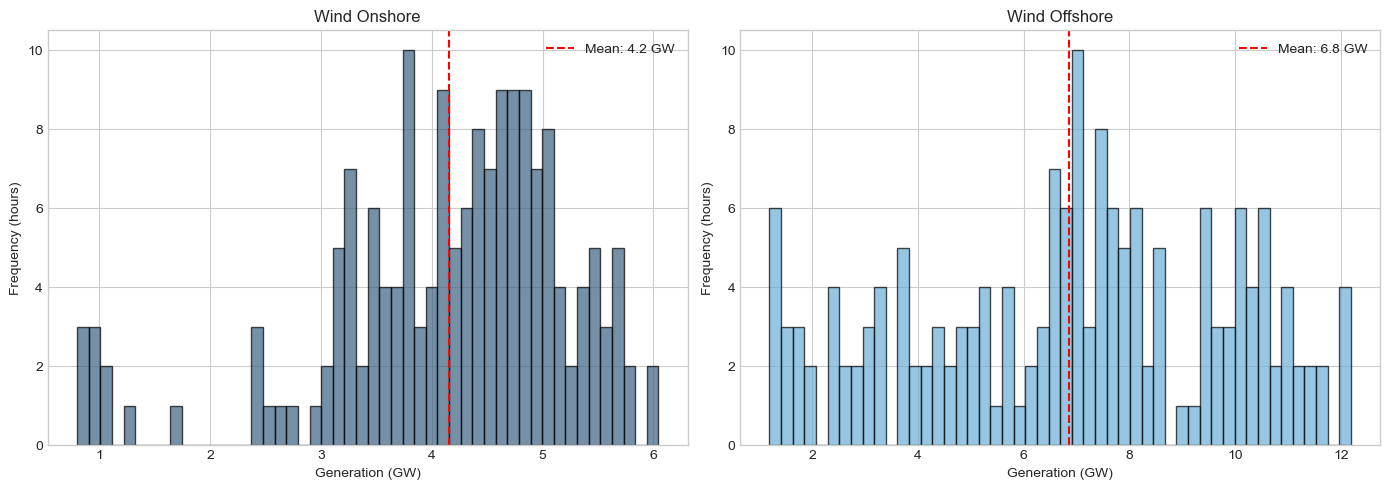

In [10]:
# Compare onshore and offshore
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

wind_cols = [c for c in renewable_gen.columns if 'wind' in c]

for idx, col in enumerate(wind_cols):
    if col in renewable_gen.columns:
        ax = axes[idx]
        ax.hist(renewable_gen[col], bins=50, color=colors.get(col), alpha=0.7, edgecolor='black')
        ax.axvline(renewable_gen[col].mean(), color='red', linestyle='--', 
                  label=f'Mean: {renewable_gen[col].mean():.1f} GW')
        ax.set_xlabel('Generation (GW)')
        ax.set_ylabel('Frequency (hours)')
        ax.set_title(col.replace('_', ' ').title())
        ax.legend()

plt.tight_layout()
plt.show()

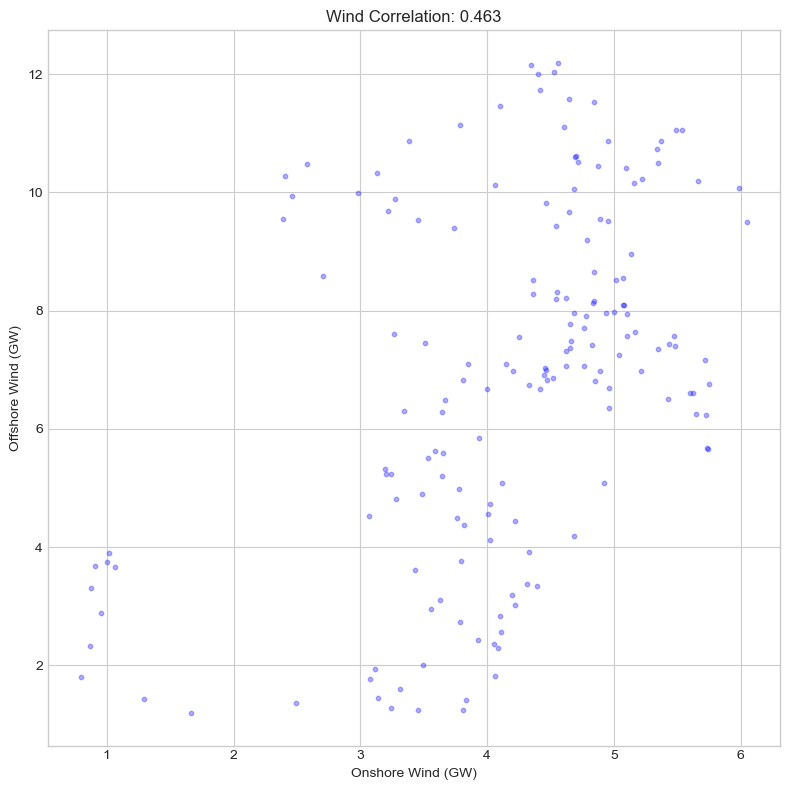

In [11]:
# Wind correlation
if 'wind_onshore' in renewable_gen.columns and 'wind_offshore' in renewable_gen.columns:
    corr = renewable_gen['wind_onshore'].corr(renewable_gen['wind_offshore'])
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    ax.scatter(renewable_gen['wind_onshore'], renewable_gen['wind_offshore'], 
              alpha=0.3, s=10, color='blue')
    ax.set_xlabel('Onshore Wind (GW)')
    ax.set_ylabel('Offshore Wind (GW)')
    ax.set_title(f'Wind Correlation: {corr:.3f}')
    
    plt.tight_layout()
    plt.show()

## 7. Solar Analysis

### 7.1 Daily Profile

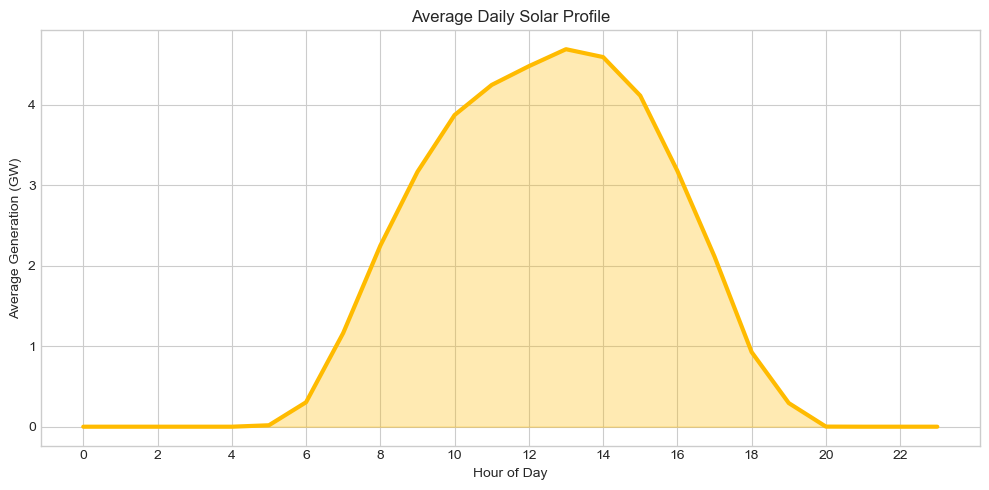

In [12]:
# Average daily solar profile
if 'solar_pv' in renewable_gen.columns:
    solar = renewable_gen['solar_pv']
    solar_hourly = solar.groupby(solar.index.hour).mean()
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    ax.plot(solar_hourly.index, solar_hourly.values, 
            color=colors['solar_pv'], linewidth=3)
    ax.fill_between(solar_hourly.index, solar_hourly.values, 
                   alpha=0.3, color=colors['solar_pv'])
    
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Average Generation (GW)')
    ax.set_title('Average Daily Solar Profile')
    ax.set_xticks(range(0, 24, 2))
    
    plt.tight_layout()
    plt.show()

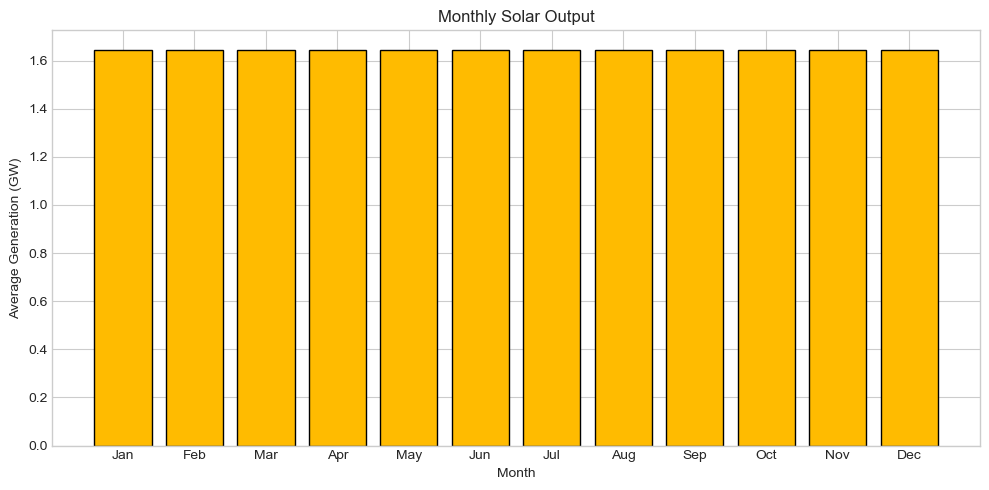

In [13]:
# Monthly solar output
if 'solar_pv' in renewable_gen.columns:
    solar_monthly = solar.groupby(solar.index.month).mean()
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ax.bar(range(1, 13), solar_monthly, color=colors['solar_pv'], edgecolor='black')
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(months)
    
    ax.set_xlabel('Month')
    ax.set_ylabel('Average Generation (GW)')
    ax.set_title('Monthly Solar Output')
    
    plt.tight_layout()
    plt.show()

## 8. Curtailment Analysis

In [14]:
# Calculate curtailment
# Curtailment = available - actual
curtailment = pd.DataFrame()

for carrier in renewable_carriers:
    carrier_gens = n.generators[n.generators.carrier == carrier].index
    carrier_gens = carrier_gens[carrier_gens.isin(n.generators_t.p.columns)]
    
    if len(carrier_gens) > 0:
        actual = n.generators_t.p[carrier_gens].sum(axis=1)
        
        # Get p_max_pu if available (time-varying capacity factor)
        if hasattr(n.generators_t, 'p_max_pu') and len(n.generators_t.p_max_pu.columns) > 0:
            available_gens = carrier_gens.intersection(n.generators_t.p_max_pu.columns)
            if len(available_gens) > 0:
                available = (n.generators_t.p_max_pu[available_gens] * 
                            n.generators.loc[available_gens, 'p_nom']).sum(axis=1)
                curtailment[carrier] = (available - actual) / 1000  # GW

if len(curtailment.columns) > 0:
    print("Curtailment by Technology (GWh):")
    for col in curtailment.columns:
        total_curtailed = curtailment[col].sum()  # GWh
        print(f"  {col}: {total_curtailed:.1f} GWh")
else:
    print("No curtailment data available (p_max_pu not found)")

Curtailment by Technology (GWh):
  wind_onshore: 272.9 GWh
  wind_offshore: 144.4 GWh
  solar_pv: 4.5 GWh
  small_hydro: 10.8 GWh


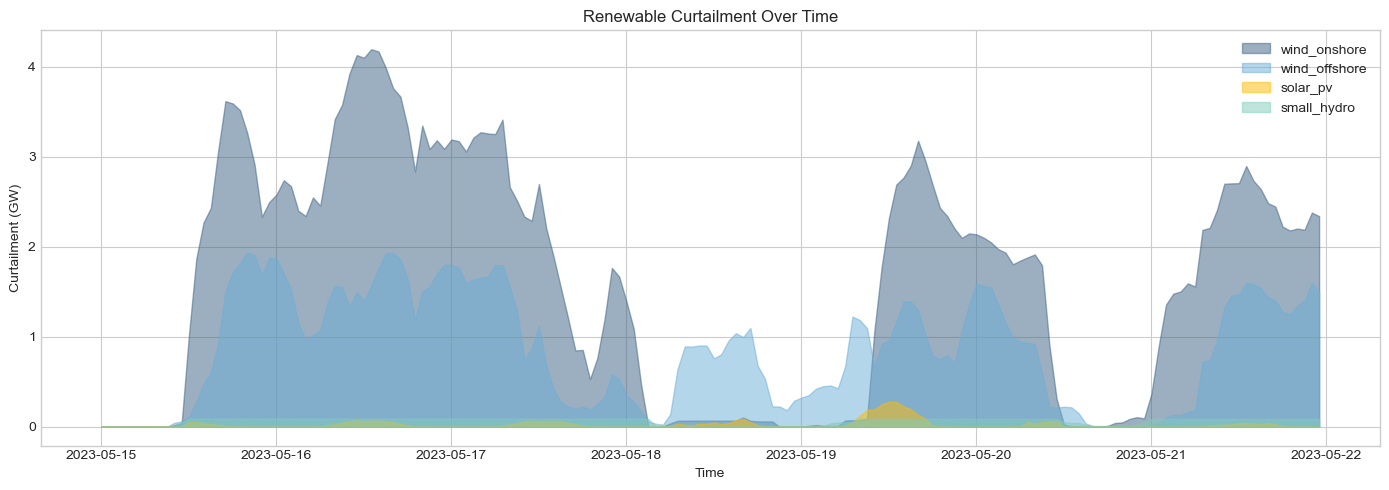

In [15]:
# Curtailment visualization
if len(curtailment.columns) > 0:
    fig, ax = plt.subplots(figsize=(14, 5))
    
    for col in curtailment.columns:
        ax.fill_between(curtailment.index, curtailment[col], 
                       alpha=0.5, color=colors.get(col, '#888888'), label=col)
    
    ax.set_ylabel('Curtailment (GW)')
    ax.set_xlabel('Time')
    ax.set_title('Renewable Curtailment Over Time')
    ax.legend()
    
    plt.tight_layout()
    plt.show()

## 9. Geographic Distribution

In [16]:
# Renewable capacity by bus
capacity_by_bus = renewables.groupby('bus')['p_nom'].sum() / 1000  # GW

print(f"Buses with renewables: {len(capacity_by_bus)}")
print(f"\nTop 10 Buses by Renewable Capacity (GW):")
print(capacity_by_bus.sort_values(ascending=False).head(10).round(2).to_string())

Buses with renewables: 449

Top 10 Buses by Renewable Capacity (GW):
bus
HUMR41    2.62
PEHE4K    1.54
NECT41    1.17
HAMB4A    1.13
KINT4J    1.08
RICH41    0.93
SIZE41    0.87
RACO41    0.78
LEIS4A    0.73
BODE41    0.58


In [17]:
# Interactive map of renewable capacity
try:
    # Convert bus coordinates from OSGB36 to WGS84 for folium
    t = Transformer.from_crs('EPSG:27700', 'EPSG:4326', always_xy=True)
    bus_coords = capacity_by_bus.index.to_series().apply(
        lambda bus: t.transform(n.buses.loc[bus, 'x'], n.buses.loc[bus, 'y'])
    )
    bus_lons = bus_coords.apply(lambda c: c[0])
    bus_lats = bus_coords.apply(lambda c: c[1])
    
    # Create folium map
    center_lat = bus_lats.mean()
    center_lon = bus_lons.mean()
    m = folium.Map(location=[center_lat, center_lon], zoom_start=6, tiles='CartoDB positron')
    
    # Add renewable capacity markers
    max_capacity = capacity_by_bus.max()
    for bus in capacity_by_bus.index:
        cap = capacity_by_bus[bus]
        lon, lat = bus_lons[bus], bus_lats[bus]
        
        # Color by capacity
        if cap > 2.0:
            color = '#DC143C'  # Crimson for >2 GW
        elif cap > 1.0:
            color = '#FF8C00'  # Orange for 1-2 GW
        elif cap > 0.5:
            color = '#FFD700'  # Gold for 0.5-1 GW
        else:
            color = '#32CD32'  # Green for <0.5 GW
        
        # Size proportional to capacity
        radius = 5 + (cap / max_capacity) * 20
        
        folium.CircleMarker(
            location=[lat, lon],
            radius=radius,
            color=color,
            fill=True,
            fillOpacity=0.6,
            tooltip=f'{bus}: {cap:.2f} GW renewable'
        ).add_to(m)
    
    # Add transmission lines for context
    for line_id in n.lines.index:
        bus0, bus1 = n.lines.loc[line_id, ['bus0', 'bus1']]
        if bus0 in n.buses.index and bus1 in n.buses.index:
            lon0, lat0 = t.transform(n.buses.loc[bus0, 'x'], n.buses.loc[bus0, 'y'])
            lon1, lat1 = t.transform(n.buses.loc[bus1, 'x'], n.buses.loc[bus1, 'y'])
            folium.PolyLine(
                [[lat0, lon0], [lat1, lon1]],
                color='gray',
                weight=0.5,
                opacity=0.3
            ).add_to(m)
    
    display(m)
    print('\nColor legend: Green (<0.5 GW) → Gold (0.5-1 GW) → Orange (1-2 GW) → Red (>2 GW)')
    
except Exception as e:
    print(f'⚠️  Interactive map unavailable: {e}')
    # Fallback to static plot
    fig, ax = plt.subplots(figsize=(10, 12))
    
    bus_x = n.buses.loc[capacity_by_bus.index, 'x']
    bus_y = n.buses.loc[capacity_by_bus.index, 'y']
    sizes = capacity_by_bus * 100
    
    scatter = ax.scatter(bus_x, bus_y, s=sizes, c=capacity_by_bus, 
                        cmap='YlOrRd', alpha=0.6, edgecolors='black', linewidth=0.5)
    
    for line in n.lines.index:
        bus0, bus1 = n.lines.loc[line, ['bus0', 'bus1']]
        if bus0 in n.buses.index and bus1 in n.buses.index:
            ax.plot([n.buses.loc[bus0, 'x'], n.buses.loc[bus1, 'x']],
                   [n.buses.loc[bus0, 'y'], n.buses.loc[bus1, 'y']],
                   color='gray', linewidth=0.3, alpha=0.5)
    
    plt.colorbar(scatter, label='Renewable Capacity (GW)', shrink=0.8)
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_title('Renewable Capacity Distribution')
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()



Color legend: Green (<0.5 GW) → Gold (0.5-1 GW) → Orange (1-2 GW) → Red (>2 GW)


## 10. Renewable Correlation Matrix

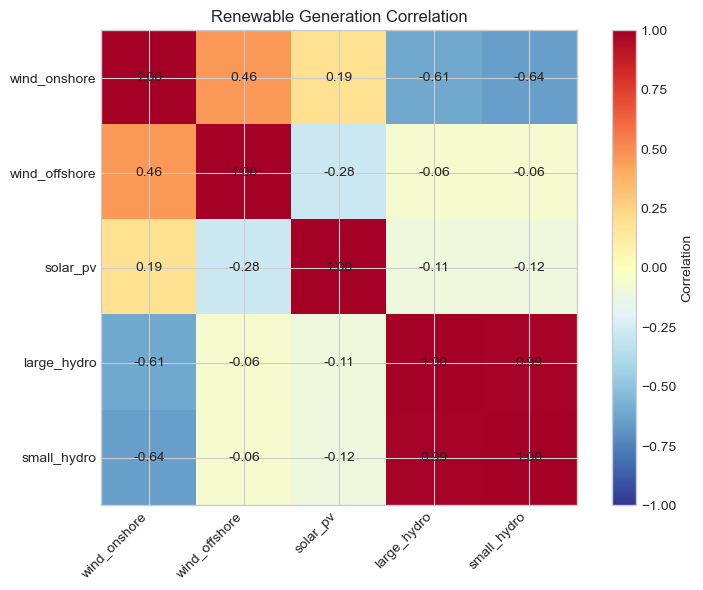

In [18]:
# Correlation between renewable sources
if len(renewable_gen.columns) > 1:
    corr_matrix = renewable_gen.corr()
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    im = ax.imshow(corr_matrix, cmap='RdYlBu_r', vmin=-1, vmax=1)
    
    ax.set_xticks(range(len(corr_matrix.columns)))
    ax.set_yticks(range(len(corr_matrix.columns)))
    ax.set_xticklabels(corr_matrix.columns, rotation=45, ha='right')
    ax.set_yticklabels(corr_matrix.columns)
    
    # Add correlation values
    for i in range(len(corr_matrix)):
        for j in range(len(corr_matrix)):
            text = ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                          ha='center', va='center', fontsize=10)
    
    plt.colorbar(im, label='Correlation')
    ax.set_title('Renewable Generation Correlation')
    
    plt.tight_layout()
    plt.show()